<a href="https://colab.research.google.com/github/Luke-code2025/AI-Ethics/blob/main/AI_Ethics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Upload data
import pandas as pd

# Load from CSV file
df = pd.read_csv('compas-scores-two-years.csv')

# Filter as done in ProPublica's analysis
df = df[(df.days_b_screening_arrest <= 30) &
        (df.days_b_screening_arrest >= -30) &
        (df.is_recid != -1) &
        (df.c_charge_degree != 'O') &
        (df.score_text != 'N/A')]

# Keep only African-American and Caucasian
df = df[df['race'].isin(['African-American', 'Caucasian'])]

# Define label (2yr recidivism) and protected attribute
df['race_binary'] = df['race'].apply(lambda x: 1 if x == 'Caucasian' else 0)
df['label'] = df['two_year_recid']

# Features to keep
features = ['sex', 'age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
            'priors_count', 'c_charge_degree', 'race_binary', 'label']

df = df[features].dropna()


In [ ]:
from aif360.datasets import BinaryLabelDataset

# Convert to BinaryLabelDataset
dataset = BinaryLabelDataset(df=pd.get_dummies(df, drop_first=True),
                             label_names=['label'],
                             protected_attribute_names=['race_binary'],
                             favorable_label=0,
                             unfavorable_label=1)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Privileged = Caucasian (1), Unprivileged = African-American (0)
privileged = [{'race_binary': 1}]
unprivileged = [{'race_binary': 0}]

# Fairness metric before mitigation
metric_orig = BinaryLabelDatasetMetric(dataset, privileged, unprivileged)
print("Original Disparate Impact:", metric_orig.disparate_impact())

# Split
train, test = dataset.split([0.7], shuffle=True)

# Reweighing
rw = Reweighing(privileged, unprivileged)
train_transf = rw.fit_transform(train)

# Train model
X_train = StandardScaler().fit_transform(train_transf.features)
y_train = train_transf.labels.ravel()

clf = LogisticRegression(solver='liblinear')
clf.fit(X_train, y_train, sample_weight=train_transf.instance_weights)

# Predict
X_test = StandardScaler().fit_transform(test.features)
y_test = test.labels.ravel()
y_pred = clf.predict(X_test)

# Evaluate predictions
test_pred = test.copy()
test_pred.labels = y_pred

metric_post = ClassificationMetric(test, test_pred, privileged, unprivileged)
print("Equal Opportunity Difference:", metric_post.equal_opportunity_difference())
print("Average Odds Difference:", metric_post.average_odds_difference())
print("Accuracy:", accuracy_score(y_test, y_pred))


Original Disparate Impact: 1.2774023521785258
Equal Opportunity Difference: -0.08066424506312342
Average Odds Difference: -0.04513010232954151
Accuracy: 0.6502525252525253


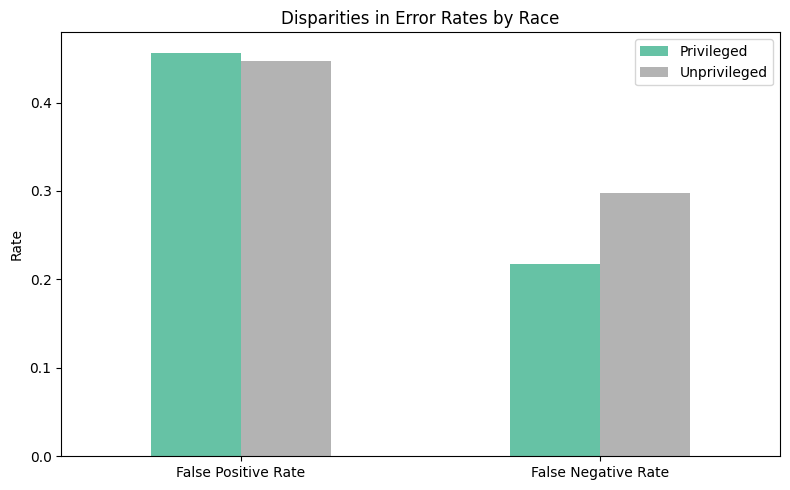

In [ ]:
import matplotlib.pyplot as plt

def plot_disparities():
    metrics = {
        "False Positive Rate": (
            metric_post.false_positive_rate(privileged=True),
            metric_post.false_positive_rate(privileged=False),
        ),
        "False Negative Rate": (
            metric_post.false_negative_rate(privileged=True),
            metric_post.false_negative_rate(privileged=False),
        )
    }

    df_metrics = pd.DataFrame(metrics, index=["Privileged", "Unprivileged"]).T
    df_metrics.plot(kind="bar", figsize=(8, 5), colormap='Set2')
    plt.title("Disparities in Error Rates by Race")
    plt.ylabel("Rate")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig("bias_disparities_custom.png")
    plt.show()

plot_disparities()
